In [1]:
import json
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, LSTM, concatenate, GlobalMaxPooling2D, RepeatVector, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg16
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import plot_model, Sequence
from livelossplot.tf_keras import PlotLossesCallback

# Tutorial on Image Caption Generation
# https://machinelearningmastery.com/develop-a-caption-generation-model-in-keras/

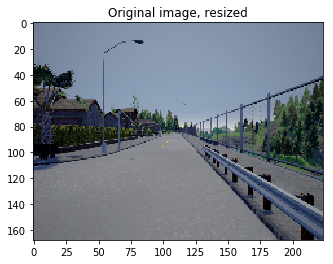

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


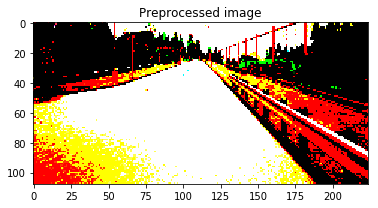

Opening:  _out/train/00017532.json
Spline:  [8.96066288e+00 1.31273347e+01 1.72939912e+01 2.14606630e+01
 9.79993435e-04 7.56471877e-04 6.41441453e-04 5.71083314e-04]


In [2]:
def load_image(path: Path):
    height, width, channels = 168, 224, 3 # 400 TODO 224x168 preserves proportions of 800x600
    image = load_img(str(path), target_size=(height, width, channels))
    return image


def load_preprocessed_image(path: Path) -> np.ndarray:
    image = load_image(path)
    image_arr = img_to_array(image)[60:, :, :]  # TODO Useless regions could be rejeted by cropping [70:, :, :]
    #print(image_arr.shape)
    
    height, width, channels = image_arr.shape
    image_reshaped = image_arr.reshape(height, width, channels)
    image_preprocessed = vgg16.preprocess_input(image_reshaped)
    return image_preprocessed


def load_spline(path: Path) -> np.ndarray:
    """FIXME It returns only distances right now!"""
    with path.open() as f:
        data = json.load(f)
    
    relative_distance = lambda waypoint: waypoint[0]
    relative_angle = lambda waypoint: waypoint[1]
    
    # FIXME Use all not, only first 4 waypointst
    # FIXME Normalize distances!
    waypoints = data['spline'][1:5]
    distances = [relative_distance(wp) for wp in waypoints]
    angles = [relative_angle(wp) for wp in waypoints]
    return np.array(distances + angles)


# Demo on example input
DATA_DIR = './_out/train'  # Must contain png and json files, named pairwise
all_img_paths = Path(DATA_DIR).glob('*.png')
example_img_path = next(all_img_paths)
example_json_path = example_img_path.with_suffix('.json')
assert example_json_path.exists()

# Image
original_image = load_image(example_img_path)
plt.title('Original image, resized')
plt.imshow(original_image)
plt.show()

image = load_preprocessed_image(example_img_path)
plt.title('Preprocessed image')
plt.imshow(image)
plt.show()

# Spline
print('Opening: ', example_json_path)
print('Spline: ', load_spline(example_json_path))

In [3]:
def extract_vgg_features(image: np.ndarray) -> np.ndarray:
    model = VGG16(include_top=False)
    model.summary()
    image = np.expand_dims(image, axis=0) # simulate one element batch
    features = model.predict(image, verbose=0)
    return features

# Demo
features = extract_vgg_features(image)
print(features.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [4]:
TRAIN_DATASET_DIR = Path('./_out/train')
TEST_DATASET_DIR = Path('./_out/test')

def dataset_generator(dataset_dir: Path, batch_size: int):
    """Replaces Keras' native ImageDataGenerator."""
    all_img_paths = list(dataset_dir.glob('*.png'))
    while True:
        batch_img_paths = np.random.choice(all_img_paths, size=batch_size)
        batch_input = []
        batch_output = []

        for img_path in batch_img_paths:
            try:
                json_path = img_path.with_suffix('.json')
                image = load_preprocessed_image(img_path)
                output_spline = load_spline(json_path)

                batch_input.append(image)
                batch_output.append(output_spline)
            except FileNotFoundError:
                # When there's no json file for image with exact name
                continue
        yield np.array(batch_input), np.array(batch_output)

# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class DatasetGenerator(Sequence):

    def __init__(self, dataset_dir: Path, batch_size: int):
        """Load paths"""
        self.batch_size = batch_size
        self.x_paths = []
        self.y_paths = []

        for img_path in dataset_dir.glob('*.png'):
            spline_json_file = img_path.with_suffix('.json')
            if spline_json_file.exists():
                self.x_paths.append(img_path)
                self.y_paths.append(spline_json_file)
                load_spline(spline_json_file) # REMOVE ME!!!!!!
        print('Dataset size: ', len(self.x_paths))
        

    def __len__(self):
        """Returns number of batches (samples)"""
        return int(np.ceil(len(self.x_paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x_paths = self.x_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_paths = self.y_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = [load_preprocessed_image(img_path) for img_path in batch_x_paths]
        batch_y = [load_spline(json_path) for json_path in batch_y_paths]
        return np.array(batch_x), np.array(batch_y)

# for X, Y in dataset_generator(TRAIN_DATASET_DIR, batch_size=100):
#     print(X.shape, Y.shape)
ds = DatasetGenerator(TRAIN_DATASET_DIR, batch_size=16)
len(ds)

Dataset size:  5623


352

In [5]:
def define_model():
    base_model = VGG16(input_shape=(108,224,3), weights='imagenet', include_top=False)
    _ = base_model.layers[-1].output
    _ = GlobalAveragePooling2D()(_)
    _ = Dense(128, activation='relu')(_)
    _ = Dense(64, activation='relu')(_)
    outputs = Dense(8, activation='linear')(_)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    model_name = 'miczi_v1'
    #print(model_name, model.summary())
    #plot_model(model, show_shapes=True, to_file=model_name +'_plot.png')
    return model

In [6]:
# Training setup
model = define_model()
BATCH_SIZE = 32

# Old, non thread-safe generator
#train_set_gen = dataset_generator(TRAIN_DATASET_DIR, batch_size=BATCH_SIZE)
#test_set_gen = dataset_generator(TEST_DATASET_DIR, batch_size=BATCH_SIZE)

# Recommended data generator
train_set_gen = DatasetGenerator(TRAIN_DATASET_DIR, batch_size=BATCH_SIZE)
test_set_gen = DatasetGenerator(TEST_DATASET_DIR, batch_size=BATCH_SIZE)


# filepath = "./training_v1/saved-model-{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpointing_callback = ModelCheckpoint(filepath,
#                                          monitor='val_acc',
#                                          verbose=1,
#                                          save_best_only=False,
#                                          mode='max',
#                                          period=10)

checkpoint_path = './training_v1/checkpoint.ckpt' # _{epoch:02d}_{val_acc:.2f}.ckpt'
checkpointing_callback = ModelCheckpoint(filepath=checkpoint_path,
                                         save_weights_only=True,
                                         monitor='val_loss',
                                         verbose=1,
                                         period=1)
plot_callback = PlotLossesCallback()
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   batch_size=BATCH_SIZE,
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_images=True)

Dataset size:  5623
Dataset size:  969


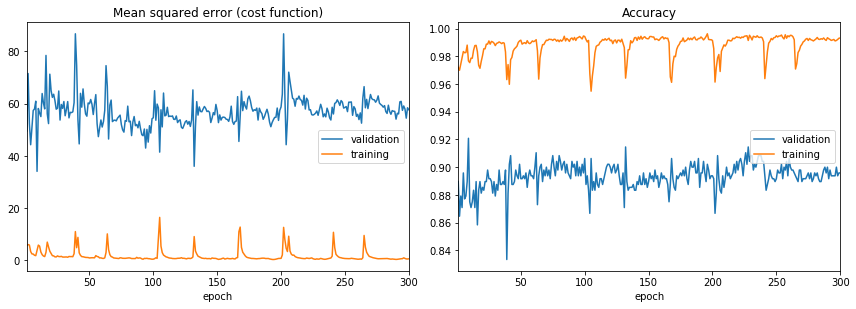

Mean squared error (cost function):
validation (min:   34.077, max:   86.782, cur:   57.688)
training   (min:    0.313, max:   16.449, cur:    0.581)

Accuracy:
validation (min:    0.833, max:    0.921, cur:    0.896)
training   (min:    0.955, max:    0.996, cur:    0.993)
176/176 [==============================] - 22s 124ms/step - loss: 0.5817 - acc: 0.9933 - val_loss: 57.6879 - val_acc: 0.8958
ls: cannot access '{checkpoint_dir}': No such file or directory


In [7]:
# Train
# model = tensorflow.keras.models.load_model('my_model.h5')
try:
    model.load_weights(checkpoint_path)
except:
    print('No checkpoint to load!!!')
model.fit_generator(train_set_gen,
                    steps_per_epoch=len(train_set_gen),
                    validation_data=test_set_gen,
                    validation_steps=len(test_set_gen) // 2,
                    shuffle=True,
                    epochs=300,
                    callbacks=[checkpointing_callback, plot_callback, tensorboard_callback],
                    verbose=1,
                    workers=20,
                    use_multiprocessing=True,
                    max_queue_size=40
                   )
!ls {checkpoint_dir}

In [ ]:
# features = model.predict(np.expand_dims(image, axis=0), verbose=1)
# print(features)
model.evaluate_generator(test_set_gen,
                        verbose=1,
                        steps=7,
                        workers=16,
                        use_multiprocessing=False,
                        max_queue_size=50)


In [ ]:
def visualize_layers(prediction):
    activations = prediction
    layer_names = []
    for layer in model.layers:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        print(n_cols)
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[:, :, col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(True)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
# Uses only VGG16 feature extractor! (without custom layers)
layer_name = 'block5_conv1'
fe_model = vgg16.VGG16(weights='imagenet', include_top=False)
fe_model = Model(model.input, model.get_layer(layer_name).output)

activations = fe_model.predict(np.expand_dims(image, axis=0) , verbose=1)
visualize_layers(activations)